In [11]:
#autoreload
%load_ext autoreload
%autoreload 2

import torch
from torchmetrics import AUROC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

import sys
sys.path.append("../../src_clasificacion_vistas/common")

import pycimg

from pathlib import Path
import cv2
from tqdm import tqdm
import numpy as np
import gc
import shutil
from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(precision=3, suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def crearMosaico(imagenes):
    """
    Crea un mosaico a partir de una lista de imágenes.
    """

    #Convertir las imágenes de tensores c x h x w float32 entre 0 y 1 a uint8 entre 0 y 255 h x w x c
    for i in range(len(imagenes)):
        imagenes[i] = (imagenes[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    
    # Obtener el tamaño de la imagen
    alto, ancho = imagenes[0].shape[:2]
    
    # Redimensionar todas las imágenes al tamaño de la primera
    # imagenes[0] = cv2.cvtColor(imagenes[0], cv2.COLOR_BGR2RGB)
    for i in range(1, len(imagenes)):
        imagenes[i] = cv2.resize(imagenes[i], (ancho, alto))
    #     imagenes[i] = cv2.cvtColor(imagenes[i], cv2.COLOR_BGR2RGB)

    # Calcular el número de filas y columnas
    num_imagenes = len(imagenes)
    num_columnas = int(np.ceil(np.sqrt(num_imagenes)))
    num_filas = int(np.ceil(num_imagenes / num_columnas))
    #print(f"num_imagenes: {num_imagenes}, num_columnas: {num_columnas}, num_filas: {num_filas}")

    # Crear una imagen en blanco para el mosaico
    mosaico = np.zeros((alto * num_filas, ancho * num_columnas, 3), dtype=np.uint8)

    # Colocar las imágenes en el mosaico
    for i, img in enumerate(imagenes):
        fila = i // num_columnas
        columna = i % num_columnas
        mosaico[fila * alto:(fila + 1) * alto, columna * ancho:(columna + 1) * ancho] = img

    return mosaico

In [40]:


def create_gold_master(data,clases,out_dir):

    fig, axes=plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios': [1, 2]})
    for d in tqdm(data):

        filenamenpz=d['filename']
        filenamejson=filenamenpz.replace(".npz",".json")
        filenamepng=filenamenpz.replace(".npz",".png")
        
        scores=d['scores']
        ground_truth=d['ground_truth']
        gts=[v for k,v in ground_truth.items() if k in clases]
        preds=[v for k,v in scores.items() if k in clases]
        defectoss=[k for k,v in scores.items() if k in clases]
        
        #filenamejson=os.path.join("..",filenamejson)
        npzfilename=filenamejson.replace(".json",".npz")
        npzfilename=os.path.join("..",npzfilename)
        filenamejson=os.path.join("..",filenamejson)


        imagenes=pycimg.npzread_torch(npzfilename,filenamejson,channel_list=['R','G','B'])
        mosaico=crearMosaico(imagenes)
    #Generar imágenes de los errores

                
        bn=os.path.basename(filenamejson)
        bn=bn.replace(".json","")        
        #fig, axes=plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 2]})

        axes[0].bar(defectoss,gts)
        axes[0].bar(defectoss,preds)

        axes[0].tick_params(axis='x',rotation=90)
        axes[0].set_ylim([0,1])
        axes[0].set_yticks(np.arange(0, 1.1, 0.1))
        axes[0].grid()



        axes[1].imshow(mosaico)
        axes[1].axis('off')
        axes[1].set_title(f'{bn}')
        nombre_fichero=os.path.join(out_dir,f"{bn}.jpg")
        fig.savefig(nombre_fichero, bbox_inches='tight', dpi=300)
        # Copy png npz and json to out_dir
        target_png=os.path.join(out_dir,f"{os.path.basename(filenamepng)}")
        target_json=os.path.join(out_dir,f"{os.path.basename(filenamejson)}")
        pngname=os.path.join("..",filenamepng)
        if os.path.exists(pngname):
            shutil.copyfile(pngname, target_png)
        else:
            print(f"File {pngname} does not exist")
        shutil.copyfile(os.path.join("..",filenamejson), target_json)
        axes[0].clear()
        axes[1].clear()


def guess_labels(data,clases,out_dir):
    '''
    Para crear JSONS empleando las predicciones como anotaciones
    '''

    fig, axes=plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios': [1, 2]})
    for d in tqdm(data):

        filenamenpz=d['filename']
        filenamejson=filenamenpz.replace(".npz",".json")
        filenamepng=filenamenpz.replace(".npz",".png")
        
        scores=d['scores']

        preds=[v for k,v in scores.items() if k in clases]
        gts=[int(p>0.5) for p in preds] ## IMPPRTANTE: Las etiquetas son las predicciones
        
        defectoss=[k for k,v in scores.items() if k in clases]
        

        npzfilename=filenamejson.replace(".json",".npz")
        npzfilename=os.path.join("..",npzfilename)
        filenamejson=os.path.join("..",filenamejson)
        print(f"filenamejson: {filenamejson}")
        with open(filenamejson, 'r') as f:
            json_data= json.load(f)

        #imagenes=pycimg.npzread_torch(npzfilename,filenamejson,channel_list=['R','G','B'])
        #mosaico=crearMosaico(imagenes)
    #Generar imágenes de los errores

                
        bn=os.path.basename(filenamejson)
        bn=bn.replace(".json","")        
        #fig, axes=plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 2]})

        # axes[0].bar(defectoss,gts)
        # axes[0].bar(defectoss,preds)

        # axes[0].tick_params(axis='x',rotation=90)
        # axes[0].set_ylim([0,1])
        # axes[0].set_yticks(np.arange(0, 1.1, 0.1))
        # axes[0].grid()



        # axes[1].imshow(mosaico)
        # axes[1].axis('off')
        # axes[1].set_title(f'{bn}')
        # nombre_fichero=os.path.join(out_dir,f"{bn}.jpg")
        # fig.savefig(nombre_fichero, bbox_inches='tight', dpi=300)
        # Copy png npz and json to out_dir
        target_png=os.path.join(out_dir,f"{os.path.basename(filenamepng)}")
        target_json=os.path.join(out_dir,f"{os.path.basename(filenamejson)}")
        pngname=os.path.join("..",filenamepng)
        # if os.path.exists(pngname):
        #     shutil.copyfile(pngname, target_png)
        # else:
        #     print(f"File {pngname} does not exist")
        for k,clase in enumerate(clases):
            json_data['annotations'][clase]=str(int(gts[k]))
        with open(target_json, 'w') as f:
            json.dump(json_data, f, indent=4)
        axes[0].clear()
        axes[1].clear()
    plt.close(fig)

def create_gold_master_pdf(data,clases,pdfname):

    with PdfPages(pdfname) as pdf:
        fig, axes=plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios': [1, 2]})
        for d in tqdm(data):

            filenamenpz=d['filename']
            filenamejson=filenamenpz.replace(".npz",".json")
            filenamepng=filenamenpz.replace(".npz",".png")
            
            scores=d['scores']
            ground_truth=d['ground_truth']
            gts=[v for k,v in ground_truth.items() if k in clases]
            preds=[v for k,v in scores.items() if k in clases]
            defectoss=[k for k,v in scores.items() if k in clases]
            
            kk=os.path.join("..",filenamejson)
            npzfilename=kk.replace(".json",".npz")


            imagenes=pycimg.npzread_torch(npzfilename,kk,channel_list=['R','G','B'])
            mosaico=crearMosaico(imagenes)
        #Generar imágenes de los errores

                    
            bn=os.path.basename(filenamejson)
            bn=bn.replace(".json","")        
            #fig, axes=plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 2]})

            axes[0].bar(defectoss,gts)
            axes[0].bar(defectoss,preds)

            axes[0].tick_params(axis='x',rotation=90)
            axes[0].set_ylim([0,1])
            axes[0].set_yticks(np.arange(0, 1.1, 0.1))
            axes[0].grid()



            axes[1].imshow(mosaico)
            axes[1].axis('off')
            axes[1].set_title(f'{bn}')
            
            pdf.savefig(fig, bbox_inches='tight', dpi=300)
            
            axes[0].clear()
            axes[1].clear()        

        


In [41]:
## Leer los archivos
test_results_json="../out_imagsSara/test_scores.json"


with open(test_results_json, "r") as f:
    test_dict = json.load(f)    

clases=list(test_dict['test_results'][0]['ground_truth'].keys())
test_data = test_dict['test_results']


# print(len(test_data))
# out_dir="/home/aalbiol/Desktop/imgs_Sara"
# Path(out_dir).mkdir(parents=True, exist_ok=True)
# create_gold_master(test_data,clases,out_dir)




In [43]:
print(len(test_data))
out_dir="/home/aalbiol/Desktop/imgs_Sara_guess"
Path(out_dir).mkdir(parents=True, exist_ok=True)
guess_labels(test_data,clases,out_dir)

548


  0%|          | 0/548 [00:00<?, ?it/s]

  2%|▏         | 11/548 [00:00<00:05, 101.53it/s]

filenamejson: ../data/imgsSara/20250422decay/20250508_1658_000149.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1657_000142.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1658_000150.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1658_002134.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1658_000152.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1658_000146.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1658_000145.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1658_000147.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1658_000151.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1659_000153.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1657_002133.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1657_000143.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1657_000144.json
filenamejson: ../data/imgsSara/20250422decay/20250508_1658_000148.json
filena

  6%|▌         | 33/548 [00:00<00:05, 101.32it/s]

filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_000202.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_000191.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_002154.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1723_002162.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1721_000189.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1721_002150.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1723_000207.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_000196.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1721_002147.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1721_002148.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1721_002151.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_002157.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_002161.json
filenamejson

 10%|█         | 55/548 [00:00<00:04, 102.16it/s]

filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_000192.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1721_002153.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_002158.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_000201.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1721_002152.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_000190.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_000194.json
filenamejson: ../data/imgsSara/20250422lightscars/20250508_1722_000200.json
filenamejson: ../data/imgsSara/20250422surface/20250509_0850_002043.json
filenamejson: ../data/imgsSara/20250422surface/20250509_0851_000040.json
filenamejson: ../data/imgsSara/20250422surface/20250509_0850_000039.json
filenamejson: ../data/imgsSara/20250422surface/20250509_0850_002042.json
filenamejson: ../data/imgsSara/20250422surface/20250509_0850_002041.json
filenamejson: ../data/imgsS

 12%|█▏        | 66/548 [00:00<00:04, 101.59it/s]

filenamejson: ../data/imgsSara/20250422cracks/20250508_1619_000140.json
filenamejson: ../data/imgsSara/20250422cracks/20250508_1619_002132.json
filenamejson: ../data/imgsSara/20250422cracks/20250508_1619_000141.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_002141.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1715_002145.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000168.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000169.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_002142.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1715_000181.json


 16%|█▌        | 88/548 [00:00<00:05, 80.01it/s] 

filenamejson: ../data/imgsSara/20250422insect/20250508_1715_000186.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_002138.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000157.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1715_000185.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000163.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000161.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000166.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000172.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_002140.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000160.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000162.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_002135.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_002137.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_0001

 20%|██        | 110/548 [00:01<00:04, 91.08it/s]

filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000175.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000174.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000171.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000177.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_002136.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000165.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000176.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_002139.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1715_000184.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000173.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000170.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000164.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1714_000159.json
filenamejson: ../data/imgsSara/20250422insect/20250508_1715_0021

 24%|██▍       | 131/548 [00:01<00:04, 94.12it/s]

filenamejson: ../data/imgsSara/20250422scars/20250509_0840_002034.json
filenamejson: ../data/imgsSara/20250422scars/20250509_0840_002032.json
filenamejson: ../data/imgsSara/20250422scars/20250509_0840_002029.json
filenamejson: ../data/imgsSara/20250422scars/20250509_0840_000038.json
filenamejson: ../data/imgsSara/20250422scars/20250509_0840_002030.json
filenamejson: ../data/imgsSara/20250422scars/20250509_0840_002033.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_000220.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002216.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_000272.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000236.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_002184.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_000274.json
filenamejson: ../data/imgsSa

 28%|██▊       | 151/548 [00:01<00:04, 94.07it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_002243.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_000295.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000241.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1733_000309.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_002167.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_000254.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002211.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_000294.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1733_002248.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_000210.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_000217.json

 32%|███▏      | 173/548 [00:01<00:03, 95.63it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_000248.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002193.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_002239.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002217.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1734_000320.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1735_000324.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_000208.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002214.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1734_000318.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_002176.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1731_002226.json

 35%|███▌      | 194/548 [00:02<00:03, 89.10it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002223.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1735_000327.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002194.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1733_002249.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_000209.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1735_000341.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002205.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1734_000321.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1734_000312.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002203.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002215.json

 37%|███▋      | 205/548 [00:02<00:03, 93.13it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_000270.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_000250.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_002174.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002218.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1731_000283.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_002241.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_002186.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002201.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002207.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1735_002262.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1731_002231.json

 41%|████      | 225/548 [00:02<00:04, 77.04it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1735_000336.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_002164.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_002244.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_000214.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002196.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_000213.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1734_000319.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_000215.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_002165.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002204.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000239.json

 45%|████▌     | 247/548 [00:02<00:03, 88.63it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_000261.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1731_000280.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1734_000316.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1735_000334.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1734_002258.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_000249.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002199.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1731_000287.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_002171.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_000268.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1735_000331.json

 49%|████▉     | 269/548 [00:02<00:02, 96.11it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_000257.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_000223.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_000256.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_000296.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_002238.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000229.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_000303.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_002237.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002197.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1731_002232.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_002179.json

 53%|█████▎    | 291/548 [00:03<00:02, 100.77it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1731_000288.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000232.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000244.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1733_002245.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000230.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_000265.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1731_000279.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_000225.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1733_000308.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_002200.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002209.json

 57%|█████▋    | 313/548 [00:03<00:02, 101.06it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_000273.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_000277.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000235.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1729_000251.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1733_002246.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1734_000323.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_002163.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002213.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_000263.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1731_002227.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_002172.json

 61%|██████    | 335/548 [00:03<00:02, 101.62it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1735_002261.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000240.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000234.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000231.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_002173.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002220.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1727_002169.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_002191.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1731_000284.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_002178.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_002180.json

 63%|██████▎   | 346/548 [00:03<00:01, 102.28it/s]

filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1732_000300.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_000238.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1728_002183.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1730_002222.json
filenamejson: ../data/imgsSara/20250423_121606_produccionnaranja/20250508_1734_000322.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_000118.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_002124.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_002125.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_000116.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_000115.json


 67%|██████▋   | 368/548 [00:04<00:02, 82.04it/s] 

filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_000114.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_002126.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_000119.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_000120.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_000113.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_000117.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_000121.json
filenamejson: ../data/imgsSara/20250422_173710_damagepliers/20250508_1536_002127.json
filenamejson: ../data/imgsSara/20250422_180310_rot/20250508_1552_000135.json
filenamejson: ../data/imgsSara/20250422_180310_rot/20250508_1552_002131.json
filenamejson: ../data/imgsSara/20250422_180310_rot/20250508_1552_000134.json
filenamejson: ../data/imgsSara/20250422_180310_rot/20250508_1551_000131.json
file

 71%|███████   | 390/548 [00:04<00:01, 91.52it/s]

filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_000079.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_002101.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_000106.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_002099.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1523_000108.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_000090.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_002088.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_002092.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_000089.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_000085.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_002097.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_002113.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2

 75%|███████▌  | 412/548 [00:04<00:01, 96.73it/s]

filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_000105.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1520_002087.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_002100.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_002098.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_002111.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_000084.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1523_000109.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_000093.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_000101.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_002091.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1520_002084.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_000081.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2

 79%|███████▉  | 434/548 [00:04<00:01, 99.69it/s]

filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_002110.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_000078.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_002112.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1523_000107.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1520_002085.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_000088.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_000102.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_002119.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_002114.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_002108.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_000094.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1520_000076.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2

 83%|████████▎ | 456/548 [00:04<00:00, 100.86it/s]

filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_002093.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_000095.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1521_000092.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_002104.json
filenamejson: ../data/imgsSara/20250422_171721_GOOD2/20250508_1522_002106.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_002054.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_000041.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_000043.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_002049.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_002047.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1503_000056.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_002043.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/2025050

 87%|████████▋ | 478/548 [00:05<00:00, 101.11it/s]

filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_000048.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_002048.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1503_000063.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_000050.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_000045.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1503_000059.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_000052.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1503_000064.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_000046.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_002051.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_000049.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_1502_002052.json
filenamejson: ../data/imgsSara/20250422_170704_GOOD/20250508_150

 89%|████████▉ | 489/548 [00:05<00:00, 99.20it/s] 

filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_002009.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0830_000035.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_002008.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0830_002023.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_002007.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_000026.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_002018.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_002013.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_000016.json


 93%|█████████▎| 510/548 [00:05<00:00, 79.74it/s]

filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0827_000011.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_000022.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_000028.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_000031.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0826_000001.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0827_000010.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0831_002025.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_000017.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_002022.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_002020.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_000025.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0827_000007.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_000033.json

 97%|█████████▋| 532/548 [00:05<00:00, 90.06it/s]

filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_002012.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0827_002005.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_000024.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_000032.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0826_002002.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0827_000003.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_002014.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_000023.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0826_000002.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0827_002003.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_002021.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_000021.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0827_000004.json

100%|██████████| 548/548 [00:05<00:00, 91.62it/s]

filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0827_000008.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0831_002027.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_002017.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0831_002026.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0829_002016.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_002006.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0827_000013.json
filenamejson: ../data/imgsSara/20250422saltamontes/20250509_0828_000018.json


In [28]:
## Leer los archivos
train_results_json="../out_imagsSara/train_scores.json"


with open(train_results_json, "r") as f:
    train_dict = json.load(f)    

clases=list(train_dict['train_results'][0]['ground_truth'].keys())
traindata = train_dict['train_results']


print(len(traindata))
out_dir="/home/aalbiol/Desktop/imgs_Alba5"
Path(out_dir).mkdir(parents=True, exist_ok=True)
guess_labels(traindata,clases,out_dir)

731


100%|██████████| 731/731 [02:15<00:00,  5.38it/s]


In [29]:
## Leer los archivos
val_results_json="../out_imagsSara/val_scores.json"


with open(val_results_json, "r") as f:
    val_dict = json.load(f)    

clases=list(val_dict['val_results'][0]['ground_truth'].keys())
valdata = val_dict['val_results']


print(len(valdata))
out_dir="/home/aalbiol/Desktop/imgs_Alba6"
Path(out_dir).mkdir(parents=True, exist_ok=True)
guess_labels(valdata,clases,out_dir)

815


100%|██████████| 815/815 [02:32<00:00,  5.34it/s]


100%|██████████| 162/162 [00:25<00:00,  6.39it/s]


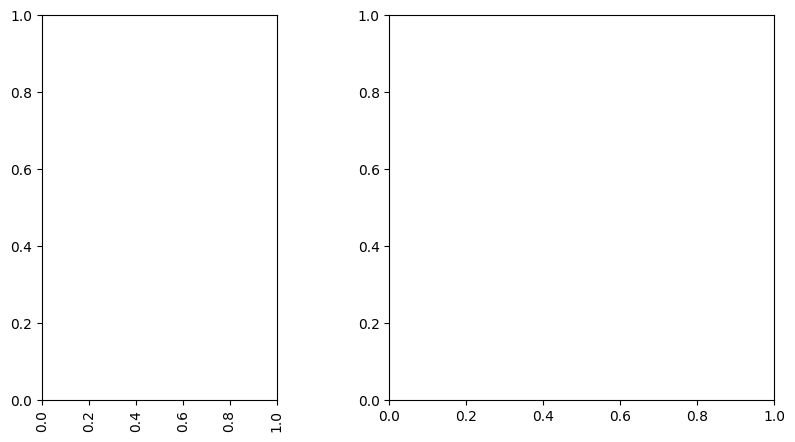

In [ ]:
# Path(out_dir).mkdir(parents=True, exist_ok=True)
# pdfname=os.path.join(out_dir,"gold_master.pdf")
# create_gold_master_pdf(test_data,clases,pdfname)